# Libraries & Packages

In [ ]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

sns.set_theme(style="darkgrid")

# for reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# for time stamps
from datetime import datetime

In [ ]:
# the tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# set up start and end times for grabbing the data
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day) # last year

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)


company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, cmp_name in zip(company_list, company_name):
    company["company_name"] = cmp_name

df = pd.concat(company_list, axis=0)
df.tail(10)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2023-12-08,145.479996,147.839996,145.399994,147.419998,147.419998,41858000,AMAZON
2023-12-11,145.660004,146.190002,143.639999,145.889999,145.889999,50907300,AMAZON
2023-12-12,145.520004,147.500000,145.300003,147.479996,147.479996,44944300,AMAZON
2023-12-13,148.119995,149.460007,146.820007,148.839996,148.839996,52766200,AMAZON
2023-12-14,149.929993,150.539993,145.520004,147.419998,147.419998,58400800,AMAZON
2023-12-15,148.380005,150.570007,147.880005,149.970001,149.970001,110039100,AMAZON
2023-12-18,150.559998,154.850006,150.050003,154.070007,154.070007,62512800,AMAZON
2023-12-19,154.399994,155.119995,152.690002,153.789993,153.789993,43171300,AMAZON
2023-12-20,152.899994,155.630005,151.559998,152.119995,152.119995,50322100,AMAZON


# Exploratory Data Analysis
* There's only 250 records (1000/4) for each company in the dataframe because weekends are not included in the data

In [ ]:
len(df)

1004

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1004 entries, 2022-12-22 to 2023-12-21
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1004 non-null   float64
 1   High          1004 non-null   float64
 2   Low           1004 non-null   float64
 3   Close         1004 non-null   float64
 4   Adj Close     1004 non-null   float64
 5   Volume        1004 non-null   int64  
 6   company_name  1004 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 62.8+ KB


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1.004000e+03
mean,179.829372,181.769694,178.134810,180.076798,179.650217,4.321186e+07
std,82.706716,83.309517,82.028505,82.694284,82.283402,2.270189e+07
min,82.800003,83.480003,81.430000,81.820000,81.820000,8.828600e+06
25%,124.394999,126.120003,123.087500,124.365002,124.349998,2.409905e+07
50%,143.730003,145.450005,142.564995,144.620003,144.570816,4.156135e+07
75%,204.265003,206.154995,202.587502,204.160000,203.671532,5.630560e+07
max,383.760010,384.299988,378.160004,382.700012,382.700012,1.581542e+08


# Stock Analysis

## What was the change in price of the stock overtime?

### Closing Price
* Definition: the **last price** at which the stock is traded on a given trading day.
* It is the standard benchmark used by investors to track its performance over time.
* **Observation** (as of December 22th, 2023):
  * All of the companies showed that their stock has matured.
  * Microsoft has the highest growth rate compared to the other companies (more fundamental analysis is required)
  * The question becomes "Why does Microsoft have the highest growth rate when their stock has matured?'

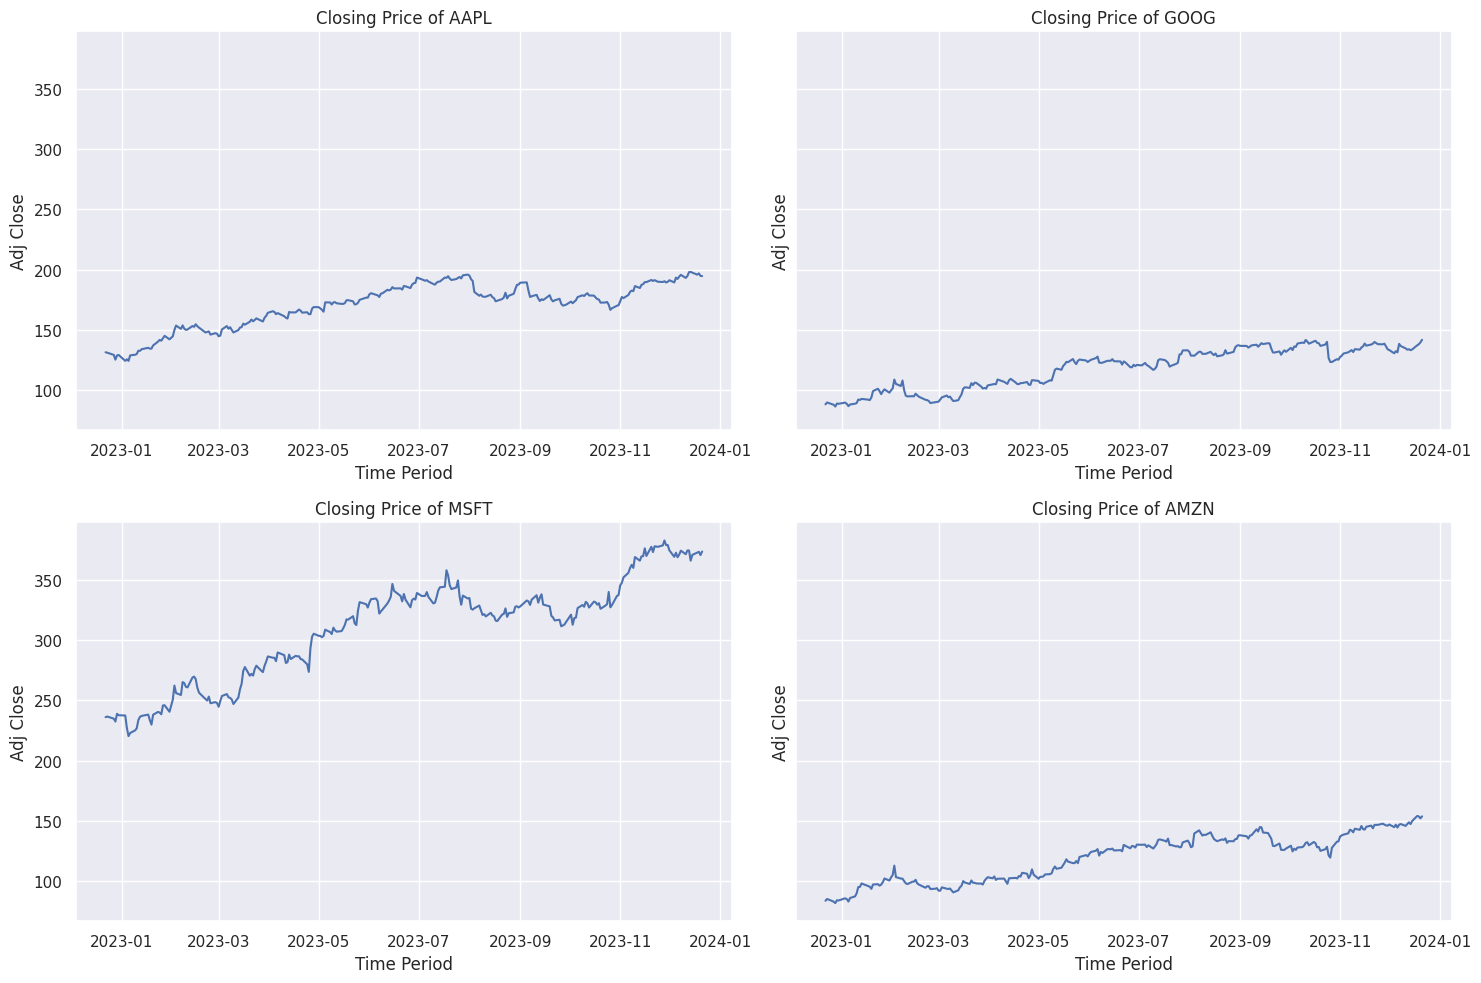

In [ ]:
# Let's see a historical view of the closing price

fig, axes = plt.subplots(2, 2, figsize=(15,10), sharey=True)

axis_x = 0
axis_y = 0
for i, company in enumerate(company_list, 1):
    y = company['Adj Close']
    axes[axis_x, axis_y].plot(y)
    axes[axis_x, axis_y].set_title(f"Closing Price of {tech_list[i - 1]}")

    axis_y += 1

    if axis_y > 1:
        axis_x += 1
        axis_y = 0

for ax in axes.flat:
    ax.set(xlabel='Time Period', ylabel='Adj Close')

fig.tight_layout() # automatically adjusts subplot params so that the subplots fits in to the figure area

### Volume of Sales
* Definition: the **total number of shares** of a stock that are traded during a specific time period, typically within a trading day.
* It is a key indicator of the level of activity and liquidity in a particular stock or the overall market.
* The volume is expressed as the total number of shares traded
* **Observations** (as of December 22th, 2023):
  * It can be seen from the graph that Apple and Amazon have higher trades than Microsoft and Google.                

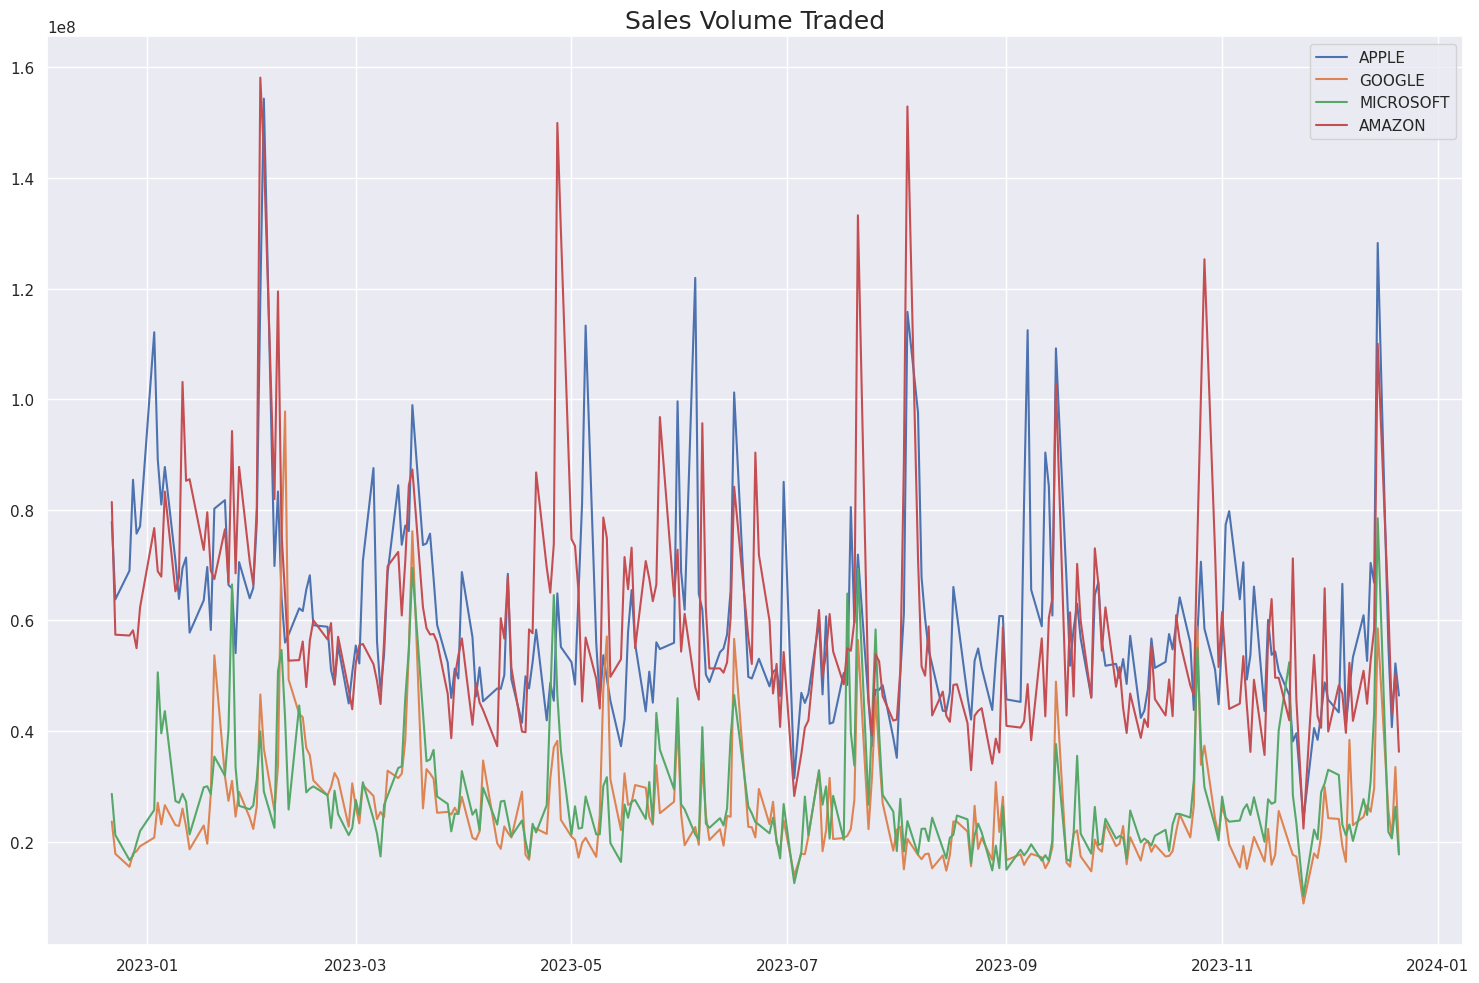

In [ ]:
fig, axes = plt.subplots(figsize=(15,10))

for i, company in enumerate(company_list, 1):
    axes.plot(company['Volume'], label=f'{company["company_name"][i-1]}')
    axes.set_title('Sales Volume Traded', fontsize=18)
    axes.legend()
fig.tight_layout()

## What was the moving average of the various stocks?
* Definition: a technical analysis tool that **smooths out price data** by creating a constantly updated average price to **identify trends** over a specified period of time: 10 days, 20 minutes, 30 weeks, or any time period the trader chooses.
* **Lag**: the time it takes for a moving average to signal a potential reversal.
* Guildelines:
  * When the closing price is above a moving average, it's uptrend (potential support).
  * When the closing price is below that moving average, it's downtrend (potential resistance, a potential reversal based on that MA)
* An MA with a *short time frame* will react much quicker to price changes than an MA with a *long time frame*.
  * An MA with a *short time frame* will more closely track the actual price
  * An MA with *short time frame* produces less **lag**.
  * An MA with *short time frame* provide more potential reversal signals
* **Observations** (as of December 22th, 2023):
  * Microsoft has the highest moving average out of the 4 giant techs. This observation aligns with the fact that Microsoft also has the highest closing price amongst the 4 companies.
  * Google has the lowest moving average out of the 4 companies. Again, this observation aligns with the conclusion we previously made that Google has the lowest closing price among the 4 giant techs.

In [25]:
ma_day = [20, 50, 100]
for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()
        # calculate the mean of consecutive ma days as it "rolls" through the series

### For 20 *Days*
* **Observations** (as of December 22nd, 2023):
  * Apple, Google, and Amazon are currently on an uptrend as the closing price > moving average. However, Apple needs to watch out for a potential reversal since the closing price is currently going down.
  * Microsoft is currently on a downtrend since the closing price < moving average.

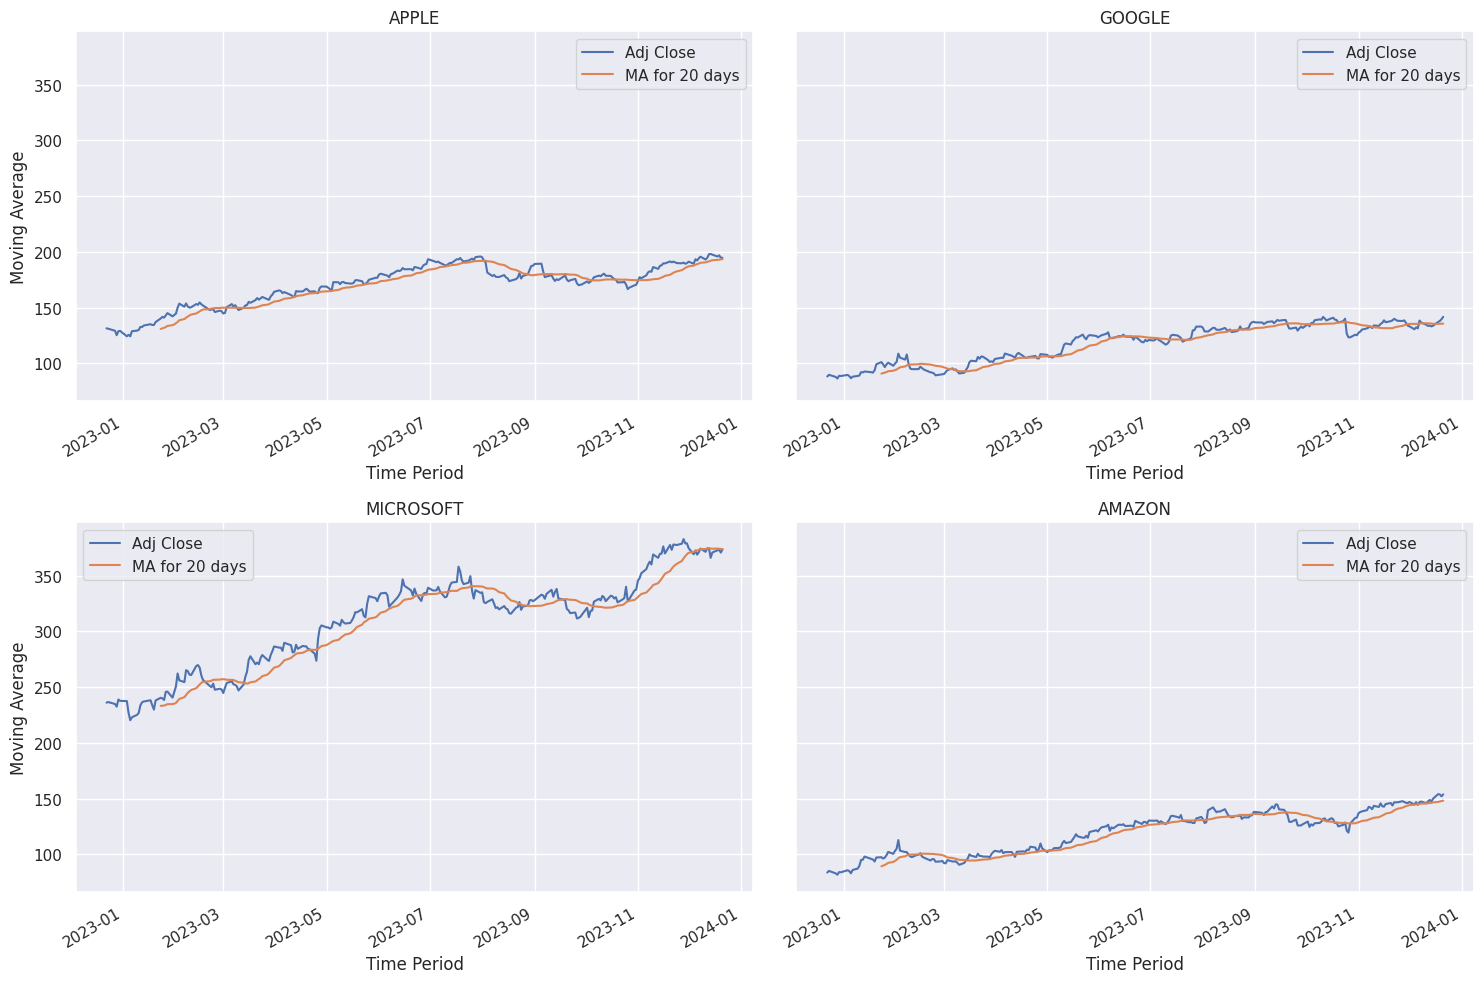

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharey=True)

axis_x = 0
axis_y = 0
for i, company in enumerate(company_list, 1):
    company[['Adj Close', 'MA for 20 days']].plot(ax=axes[axis_x, axis_y])
    axes[axis_x, axis_y].set_title(f'{company["company_name"][i-1]}')

    axis_y += 1

    if axis_y > 1:
        axis_x += 1
        axis_y = 0

for ax in axes.flat:
    ax.set(xlabel='Time Period', ylabel='Moving Average')


fig.tight_layout()

### For 100 Days
* **Observations** (as of December 22nd, 2023):
  * A little bit different from observations made when we our look-back period was 20 days, the moving average with a look-back period of 100 days indicates that ALL comapnies are having an uptrend.
  * Mircosoft and Apple (again) need to watch out since their stock prices are decreasing.  

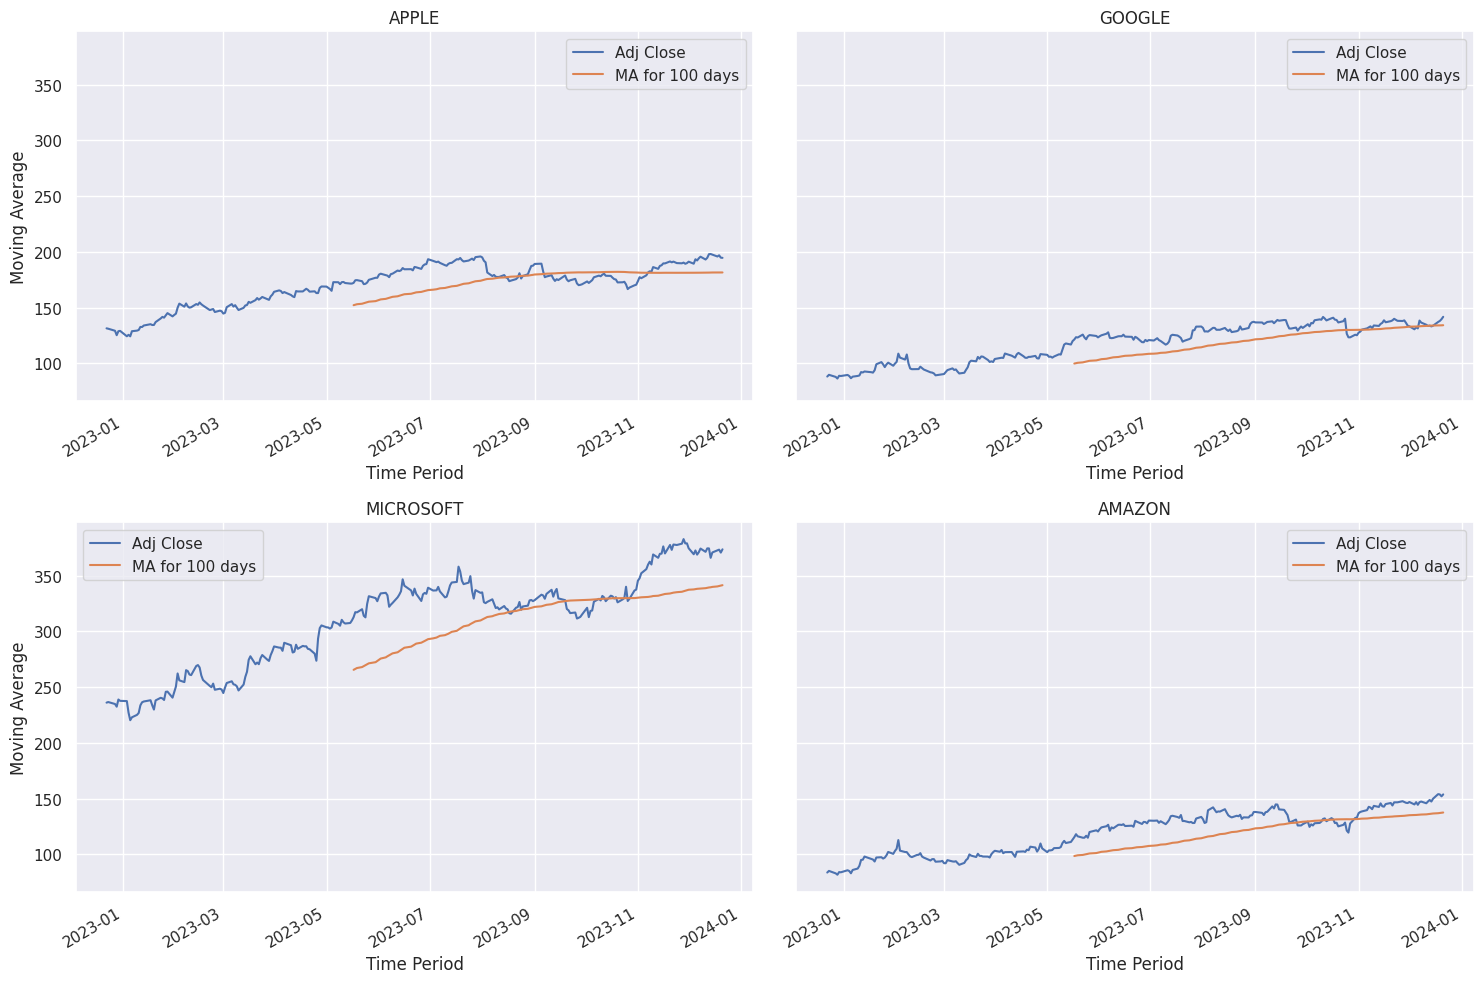

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharey=True)

axis_x = 0
axis_y = 0
for i, company in enumerate(company_list, 1):
    company[['Adj Close', 'MA for 100 days']].plot(ax=axes[axis_x, axis_y])
    axes[axis_x, axis_y].set_title(f'{company["company_name"][i-1]}')

    axis_y += 1

    if axis_y > 1:
        axis_x += 1
        axis_y = 0

for ax in axes.flat:
    ax.set(xlabel='Time Period', ylabel='Moving Average')


fig.tight_layout()

### Short-term + Long-term Period
* Guidelines:
  * When the shorter-term MA crosses *above* the longer-term MA, it's signalling an uptrend. It's called a **buy signal**. It is also known as a **golden cross**.
  * When the shorter-term MA crosses *below* the longer-term MA, it's signalling a downtrend. It's called a **sell signal**. It is also known as a **dead/death cross**.
* **Observations** (as of December 22th, 2023):
  * All the companies have a tiny dip a little bit before and around November 2023 before their closing price rises. This indicate there might be a major events during those moments that impact the closing price of these companies.
  * Apple's stock's graph indicate a buy signal or provide a golden cross around the end of 2023-11 or early 2023-12.
  * Google's stock is having an uptrend in general
  * Microsoft's stock's graph indicate a death cross around 2023-10 and golden cross on 2023-11. However, as the moving average is above the proce, this could signal a potential reversal and it might not be prudent to buy for a short-term investment.
  * Amazon's stock's graph indicate a death cross around 2023-10 and golden cross around 2023-11. Currently, Amazon is observing an uptrend in general.

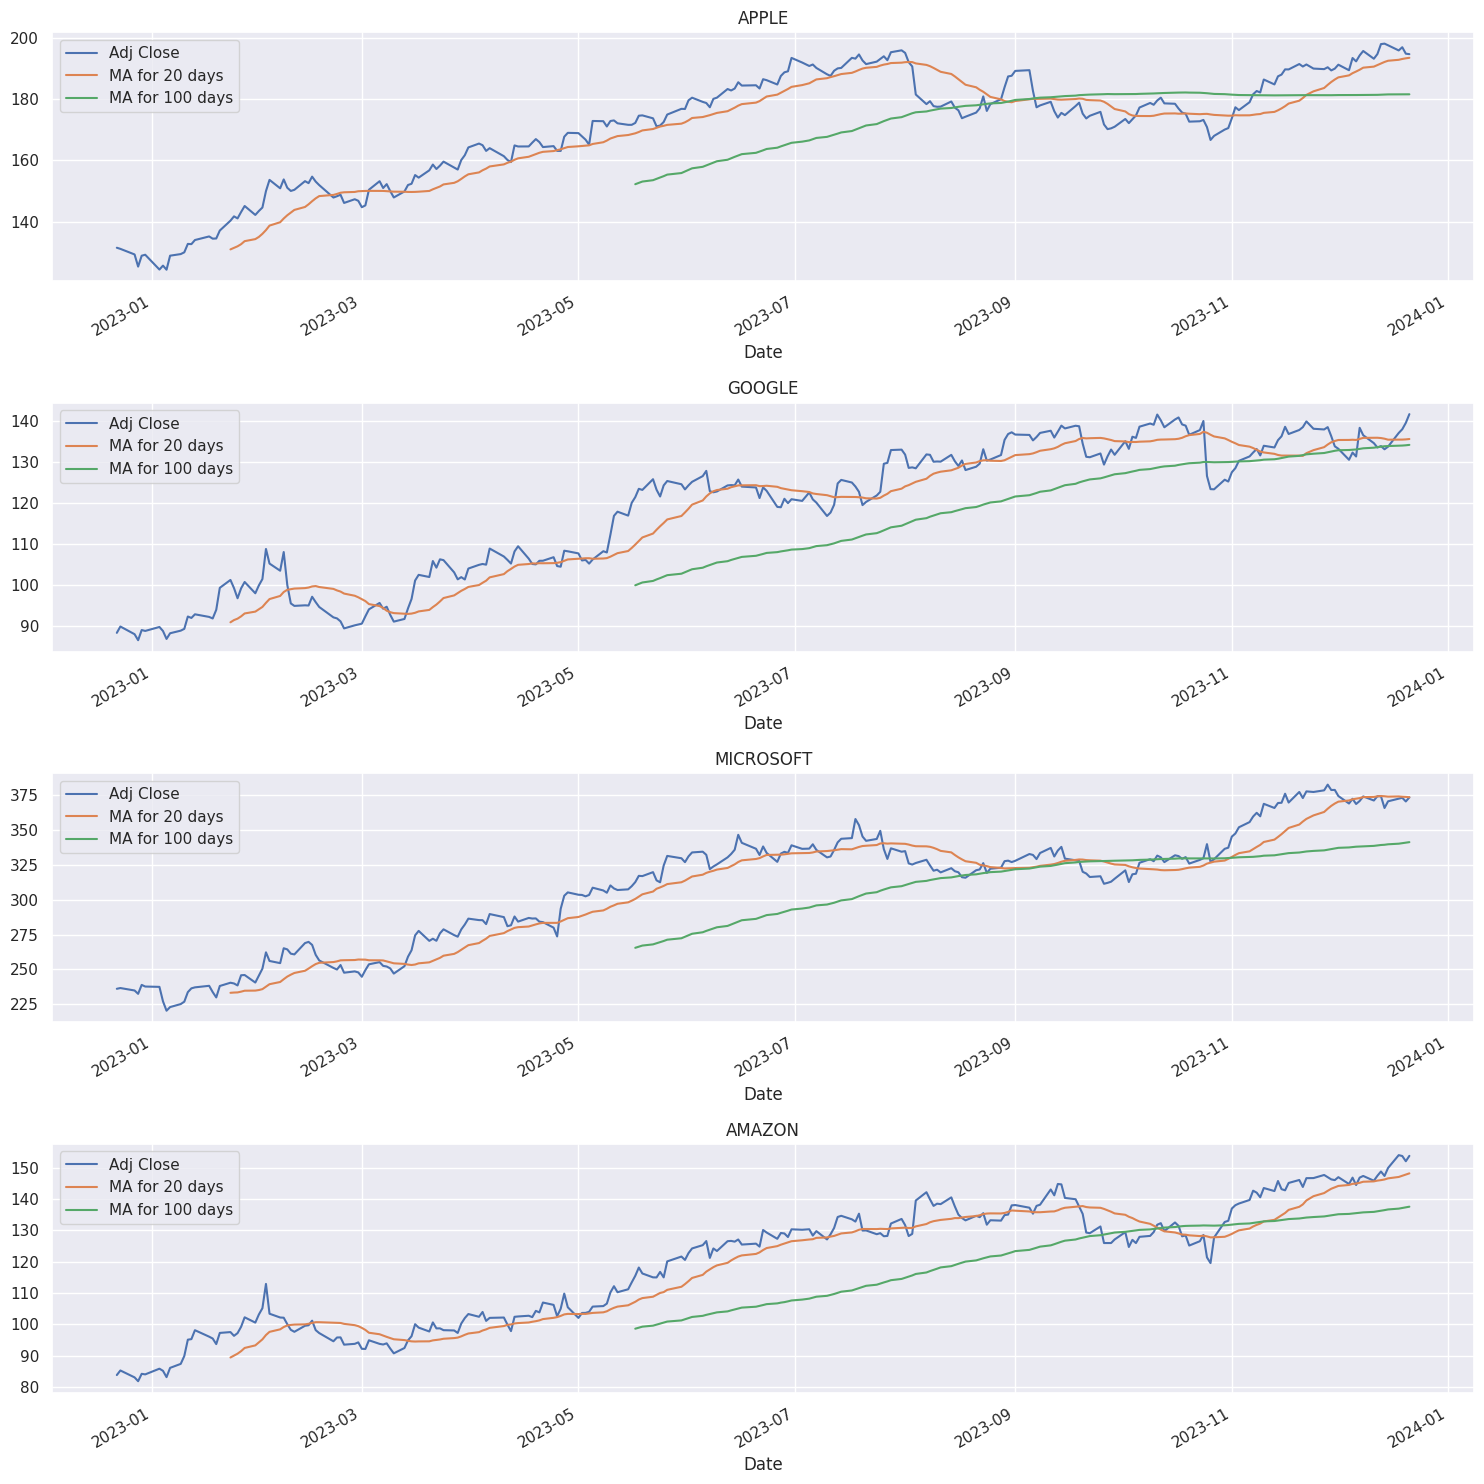

In [34]:
fig, axes = plt.subplots(4, figsize=(15,15))
for i, company in enumerate(company_list, 1):
    company[['Adj Close', 'MA for 20 days', 'MA for 100 days']].plot(ax=axes[i-1])
    axes[i-1].set_title(f"{company['company_name'].unique()[0]}")

fig.tight_layout()

## What was the daily return of the stock on average?
* Dive into the daily changes of the stock to analyze the risk of the stock (not just the absolute value).
* The metric is percentage
* **Observations** (as of December 20th, 2023):
  * Apple has the most consistent daily return since there's relativly no apparent points that are particularly high or low.
    * Moreover, Apple possesses the smallest standard deviation (0.013) and spread as can be seen from the histogram
  * Google and Amazon have more volatile daily returns with more spikes and dips compared to the rest.
    * This observation can be confirmed by looking at
      * The standard deviation where the standard deviation of the daily return of Google's and Amazon's stock (0.019 and 0.021, respectively) is higher than the other two stocks.
      * The histogram where the spread of daily return of Google's and Amazon's stocks are wider than the other two stocks.
* TODO: calculate the standard deviation to confirm our suspicisions
* TODO: create a box plot

In [35]:
# use pct_change to find the percent change for each day
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

### Graph of Daily Return of Each Company's Stock

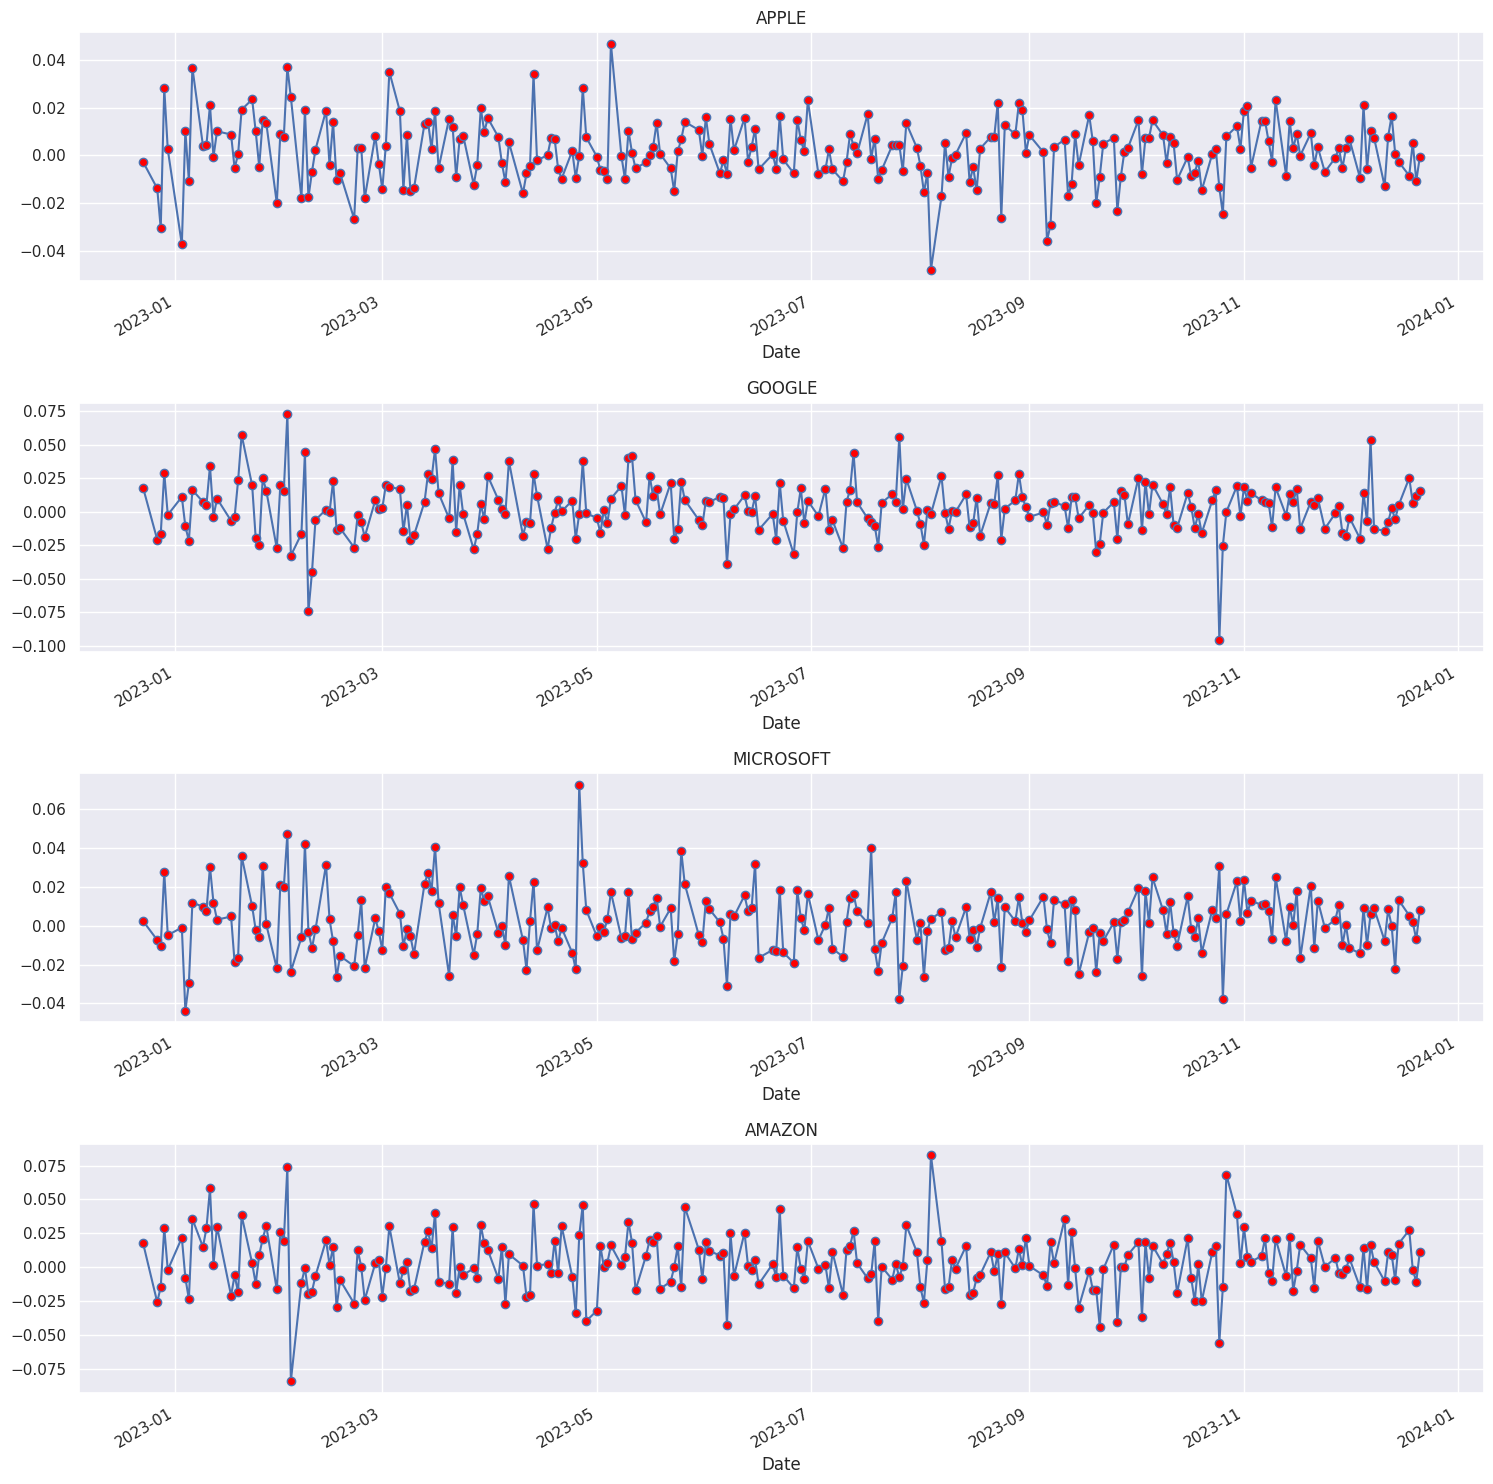

In [36]:
fig, axes = plt.subplots(4, figsize=(15,15))
for i, company in enumerate(company_list, 1):
    company['Daily Return'].plot(ax=axes[i-1], marker='o', markerfacecolor='red')
    axes[i-1].set_title(f"{company['company_name'].unique()[0]}")

fig.tight_layout()

### Spread of the Daily Return of Each Company's Stock

#### Standard Deviation

In [42]:
for i, company in enumerate(company_list, 1):
    std = np.std(company['Daily Return'])
    print(f"Standard Deviation of {company['company_name'].unique()[0]}'s Daily Return is {std:.3f}")


Standard Deviation of APPLE's Daily Return is 0.013
Standard Deviation of GOOGLE's Daily Return is 0.019
Standard Deviation of MICROSOFT's Daily Return is 0.016
Standard Deviation of AMAZON's Daily Return is 0.021


#### Histograms

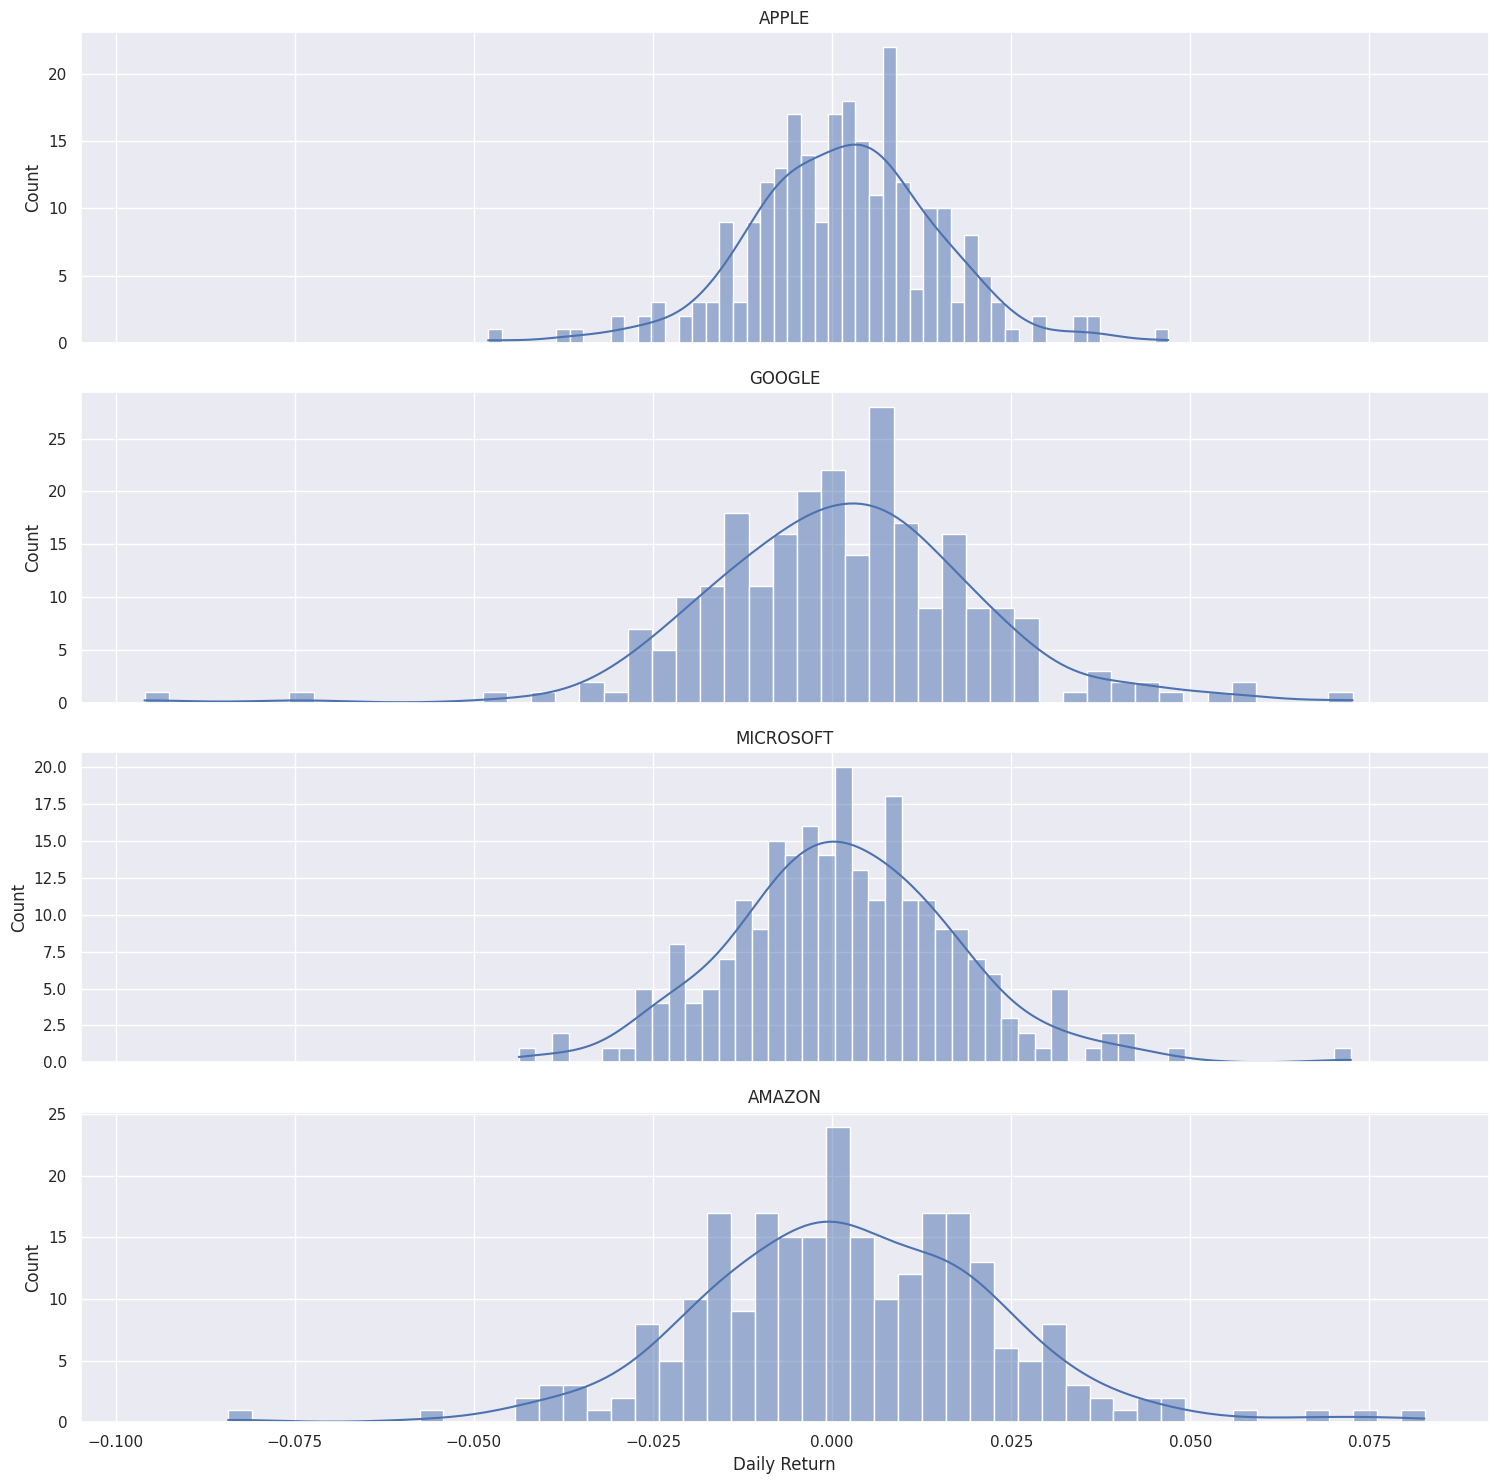

In [ ]:
n_bins = 50

fig, ax = plt.subplots(4, figsize=(15,15), sharex=True)


for i, company in enumerate(company_list, 1):
    sns.histplot(ax=ax[i-1], data=company, x='Daily Return', bins = n_bins, kde=True).set_title(f'{company["company_name"][i-1]}')



fig.tight_layout()

## What was the correlation between different stocks closing prices?
* Correlation measures the degree of relation between two variables (positive or negative)
* The value must fall between -1.0 and +1.0.
* Correlation doesn’t show:
  * if x causes y or vice versa
  * if the association is caused by a third factor.
* **Observations** (as of December 22nd, 2023):
  * Google and Amazon have the strongest correlation on closing prices.
  * Google and Apple have the weakest correlation on closing prices.

In [ ]:
# Grab all the closing prices for the tech stock list into one DataFrame

closing_df = pdr.get_data_yahoo(tech_list, start=start, end=end)['Adj Close']

# Make a new tech returns DataFrame
tech_returns = closing_df.pct_change()
tech_returns.head()

[*********************100%%**********************]  4 of 4 completed


,AAPL,AMZN,GOOG,MSFT
Date,,,,
2022-12-19,NaN,NaN,NaN,NaN
2022-12-20,-0.000529,0.003180,0.005384,0.005614
2022-12-21,0.023810,0.018547,0.006917,0.010877
2022-12-22,-0.023773,-0.034344,-0.022050,-0.025529
2022-12-23,-0.002798,0.017425,0.017562,0.002267


### Ex: Correlation of Google vs Microsoft Daily Return

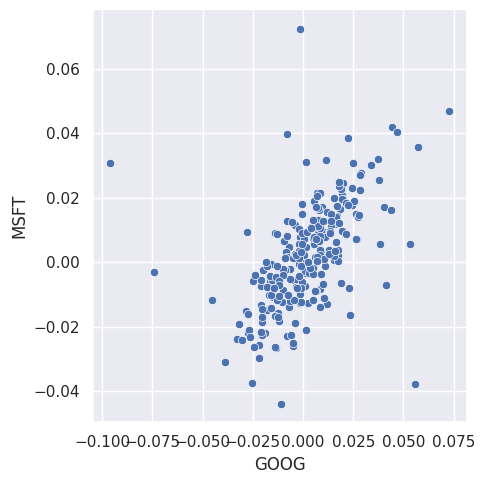

In [ ]:
sns.relplot(data=tech_returns, x="GOOG", y="MSFT")

### Comparisons of Closing Price (`sns.PairGrid`)

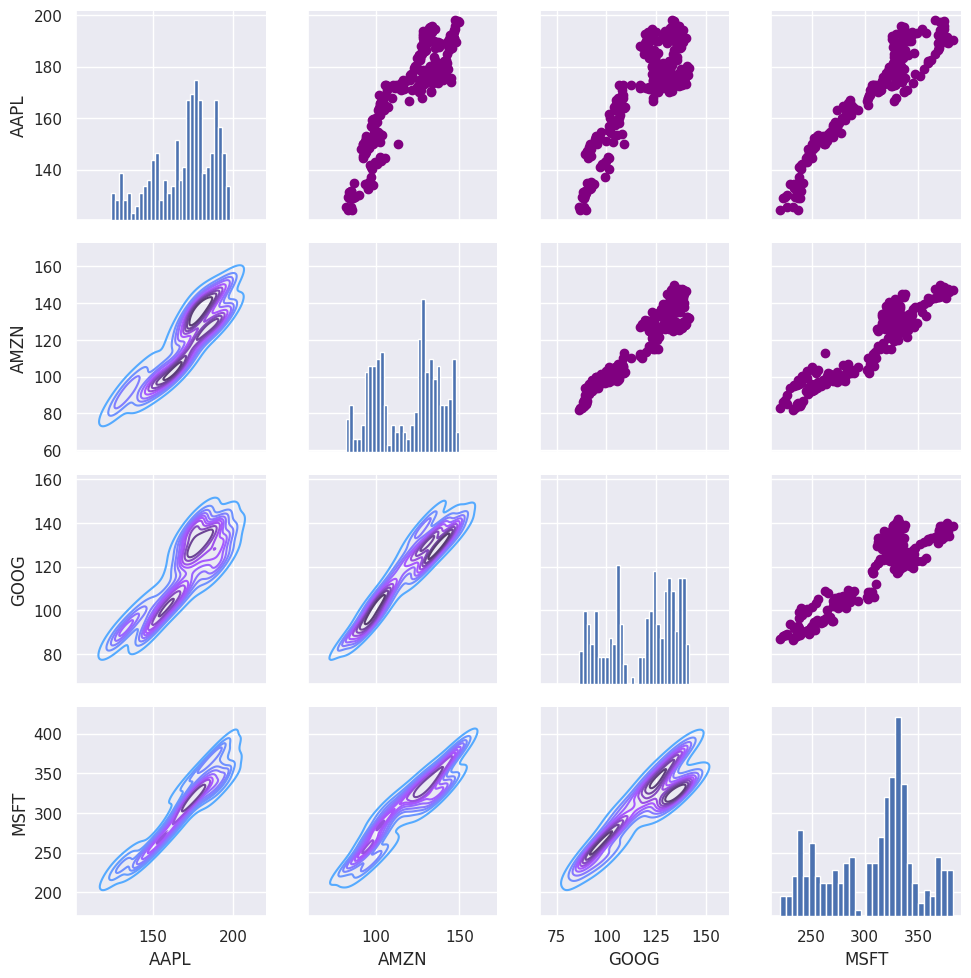

In [ ]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
closing_price_pairgrid = sns.PairGrid(closing_df)

# Using map_upper we can specify what the upper triangle will look like.
closing_price_pairgrid.map_upper(plt.scatter,color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
closing_price_pairgrid.map_lower(sns.kdeplot,cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
closing_price_pairgrid.map_diag(plt.hist,bins=30)

### Numerical Correlation

Text(0.5, 1.0, 'Correlation of stock closing price')

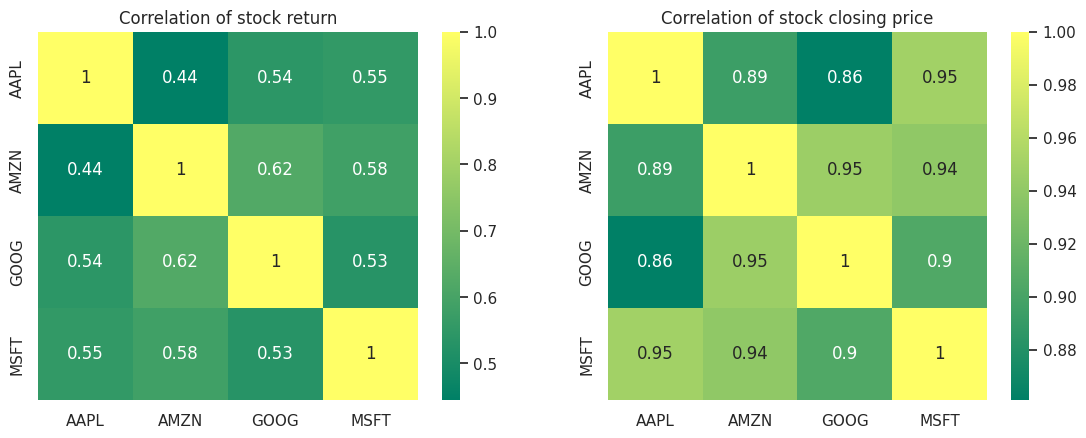

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_returns.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

## What are the correlation between US Economics Growth & Each Company's Stocks?

## How much value do we put at risk by investing in a particular stock?
* One of the most basic ways is to comparing the expected return (mean) with the risk (standard deviation) of the daily returns.

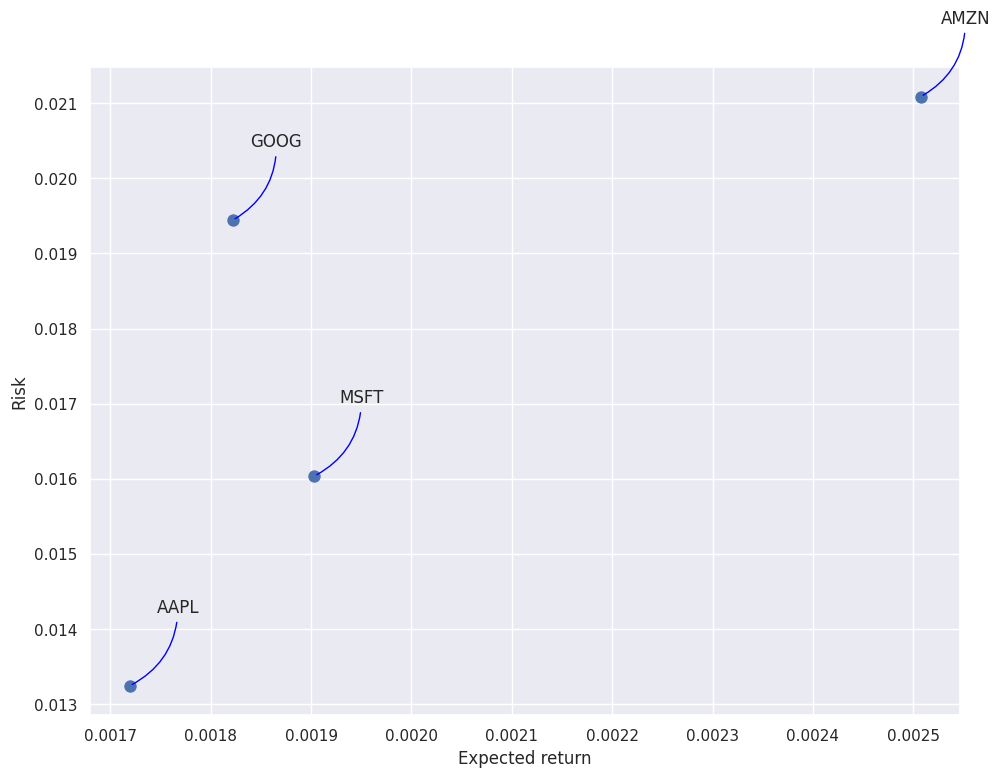

In [ ]:
returns = tech_returns.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(returns.mean(), returns.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(returns.columns, returns.mean(), returns.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom',
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

# Prediction for the Next Closing Price

## Apple

In [ ]:
apple_df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())

[*********************100%%**********************]  1 of 1 completed


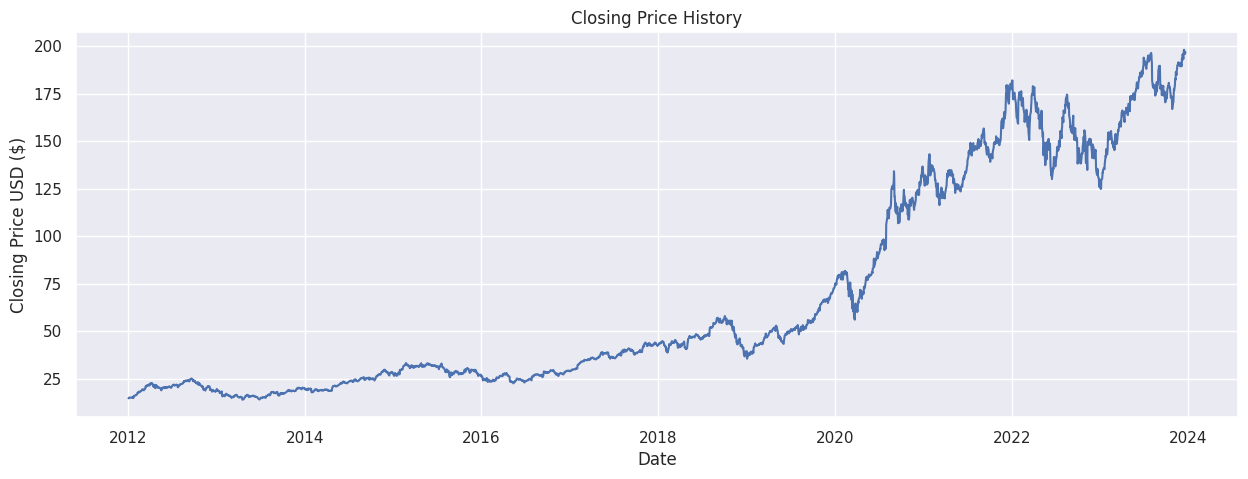

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Closing Price History')
plt.plot(apple_df['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price USD ($)')
plt.show()

In [ ]:
# filter the dataframe with only the closing price
data = apple_df.filter(['Close'])
# convert the dataframe to a numpy array
dataset = data.values
# number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * .95 ))
print(training_data_len)

2861


In [ ]:
# scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [ ]:
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0]) #the first 60 rows
    y_train.append(train_data[i, 0]) # the last row being the ground truth value
    # if i<= 61:
    #     print(x_train)
    #     print(y_train)
    #     print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
print("before reshape")
print(x_train.shape)
print(x_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print("after reshape")
print(x_train.shape)
print(x_train)

before reshape
(2801, 60)
[[0.00401431 0.00444289 0.00533302 ... 0.04197573 0.0434302  0.04403914]
 [0.00444289 0.00533302 0.00618049 ... 0.0434302  0.04403914 0.04253425]
 [0.00533302 0.00618049 0.00605056 ... 0.04403914 0.04253425 0.04053485]
 ...
 [0.76770516 0.75890861 0.7526098  ... 0.85697416 0.8666938  0.86772551]
 [0.75890861 0.7526098  0.73050971 ... 0.8666938  0.86772551 0.86131817]
 [0.7526098  0.73050971 0.73284465 ... 0.86772551 0.86131817 0.85860317]]
after reshape
(2801, 60, 1)
[[[0.00401431]
  [0.00444289]
  [0.00533302]
  ...
  [0.04197573]
  [0.0434302 ]
  [0.04403914]]

 [[0.00444289]
  [0.00533302]
  [0.00618049]
  ...
  [0.0434302 ]
  [0.04403914]
  [0.04253425]]

 [[0.00533302]
  [0.00618049]
  [0.00605056]
  ...
  [0.04403914]
  [0.04253425]
  [0.04053485]]

 ...

 [[0.76770516]
  [0.75890861]
  [0.7526098 ]
  ...
  [0.85697416]
  [0.8666938 ]
  [0.86772551]]

 [[0.75890861]
  [0.7526098 ]
  [0.73050971]
  ...
  [0.8666938 ]
  [0.86772551]
  [0.86131817]]

 [[0.7

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2801/2801 [==============================] - 168s 58ms/step - loss: 0.0011


In [ ]:
test_data = scaled_data[training_data_len - 60: , :]

x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 [==============================] - 1s 35ms/step


6.84360151179364

<ipython-input-34-0cdd5e68a3a9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


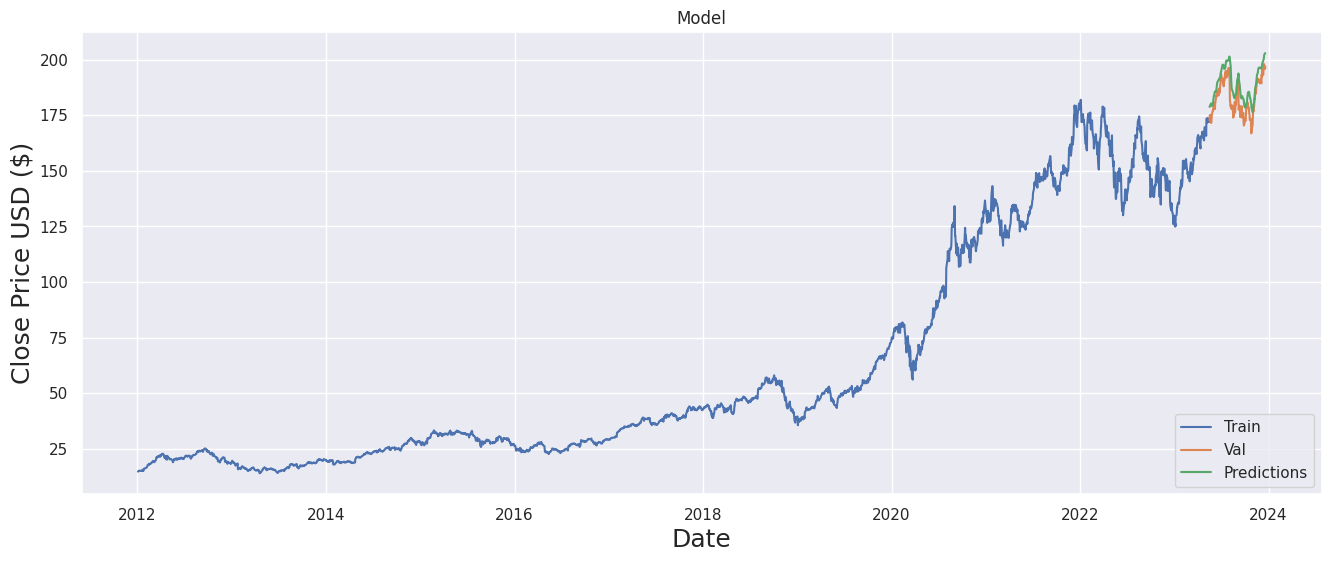

In [ ]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

## Microsoft

## Google

## Amazon